# **Статистика для анализа данных**

## **Лабораторная работа №5**  
###**Временные ряды**


---


**Работу выполнили студенты :**
  - Бабич Александр Петрович, ИСУ: 412882,  Практический поток: 1.3  
  - Московкин Александр Николаевич, ИСУ: 472264,  Практический поток: 1.3  

# Подготовка

## Импорт библиотек

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 6)

## Загрузка данных

В качестве примера возьмем цены закрытия акций TESLA (TSLA) за последние несколько лет

In [13]:
ticker = 'TSLA'
start_date = '2019-01-01'
end_date = '2023-12-31'

data = yf.download(ticker, start=start_date, end=end_date, progress=True)

[*********************100%***********************]  1 of 1 completed


In [14]:
data

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2019-01-02,20.674667,21.008667,19.920000,20.406668,174879000
2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000
2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500
2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000
2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500
...,...,...,...,...,...
2023-12-22,252.539993,258.220001,251.369995,256.760010,93249800
2023-12-26,256.609985,257.970001,252.910004,254.490005,86892400


In [15]:
if data.empty:
    raise ValueError(f"Не удалось загрузить данные для тикера {ticker}. yf.download вернул пустой DataFrame.")

if 'Close' not in data.columns:
    raise KeyError(f"Столбец 'Close' не найден в загруженных данных. Доступные столбцы: {data.columns}")
else:
    close_data_column = data['Close']
    data_series = close_data_column.squeeze()

if data_series.empty:
    raise ValueError(f"Извлеченный временной ряд для тикера '{ticker}' оказался пустым.")

In [16]:
data_series.head()

,TSLA
Date,
2019-01-02,20.674667
2019-01-03,20.024000
2019-01-04,21.179333
2019-01-07,22.330667
2019-01-08,22.356667


# Выполнение Лабораторной работы

### 1. Визуализация данных

#### График нашего временного ряда

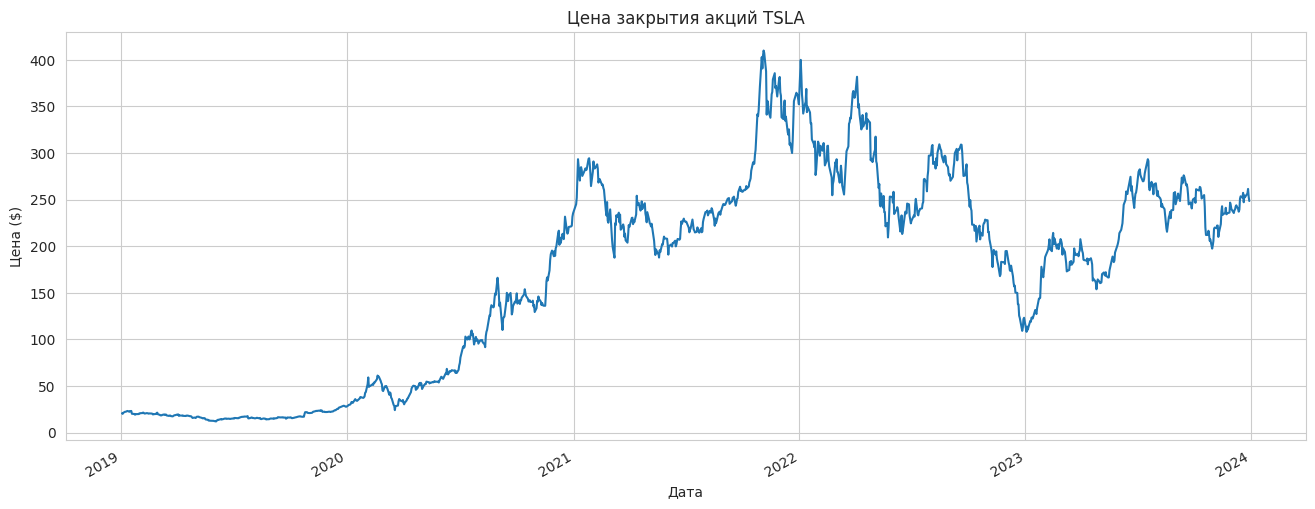

In [17]:
plt.figure()
data_series.plot(title=f'Цена закрытия акций {ticker}')
plt.xlabel('Дата')
plt.ylabel('Цена ($)')
plt.show()

Виден восходящий тренд с поправкой на мировую ситуацию в 22 году.

#### Графики разностных рядов различного порядка

Разностные ряды помогают стабилизировать среднее значение ряда, т.е. убрать тренд. Первый разностный ряд — это изменения между соседними наблюдениями. Второй — изменения изменений.

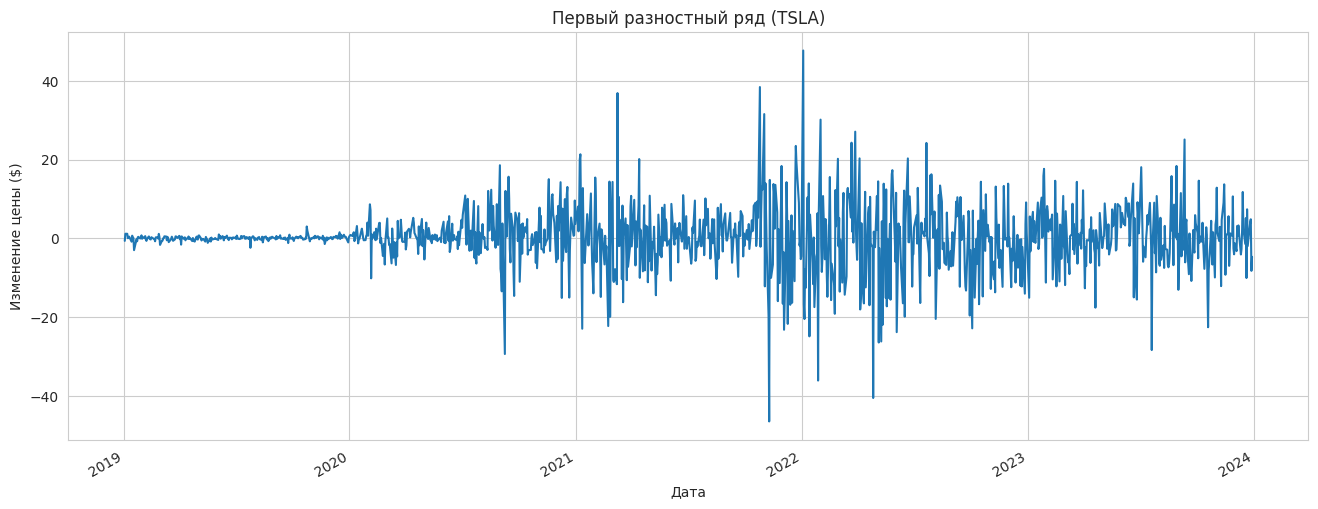

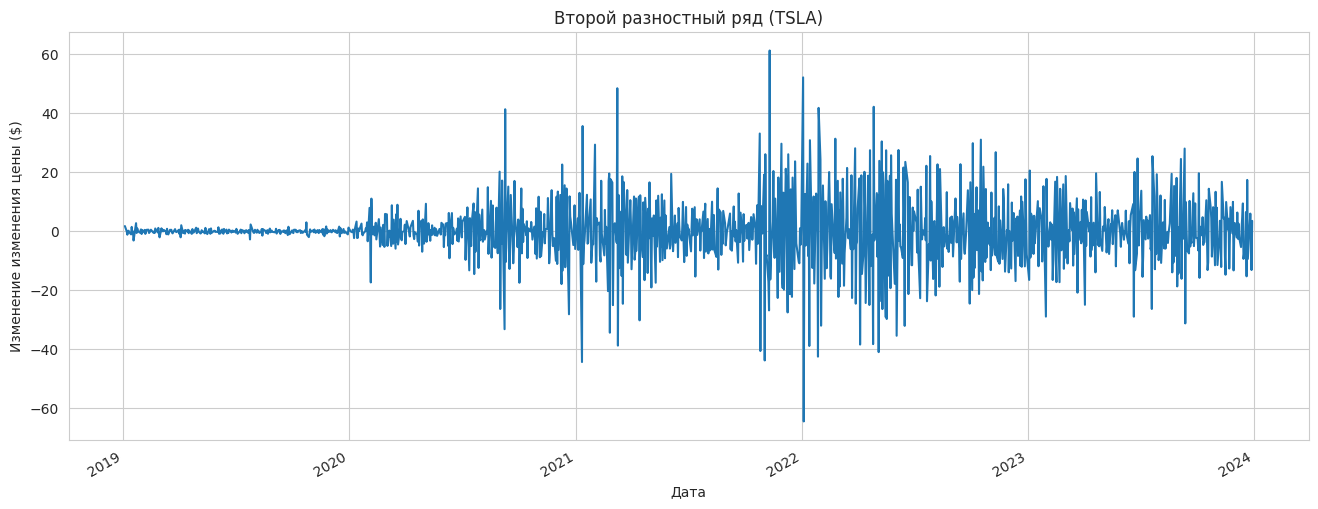

In [18]:
diff_series_1 = data_series.diff().dropna()

diff_series_2 = diff_series_1.diff().dropna()

plt.figure()
diff_series_1.plot(title=f'Первый разностный ряд ({ticker})')
plt.xlabel('Дата')
plt.ylabel('Изменение цены ($)')
plt.show()

plt.figure()
diff_series_2.plot(title=f'Второй разностный ряд ({ticker})')
plt.xlabel('Дата')
plt.ylabel('Изменение изменения цены ($)')
plt.show()



- **Первый разностный ряд**: Часто выглядит более "стационарным", чем исходный: его значения колеблются вокруг нуля(особенно до 2021), тренд устранен. Это ежедневные приросты/убытки цены. Но после 2021 начинаются резкие скачки "туда - сюда"
- **Второй разностный ряд**: Еще одна степень разности. Иногда это помогает, если первый ряд все еще показывает тренд. Так же цены колеблятся еще сильнее

### 2. АКФ (Автокорреляционная функция)

#### Построение автокорреляционной функции ряда

АКФ показывает, насколько значения ряда коррелируют со своими прошлыми значениями (лагами). Это помогает определить наличие тренда, сезонности.

<Figure size 1600x600 with 0 Axes>

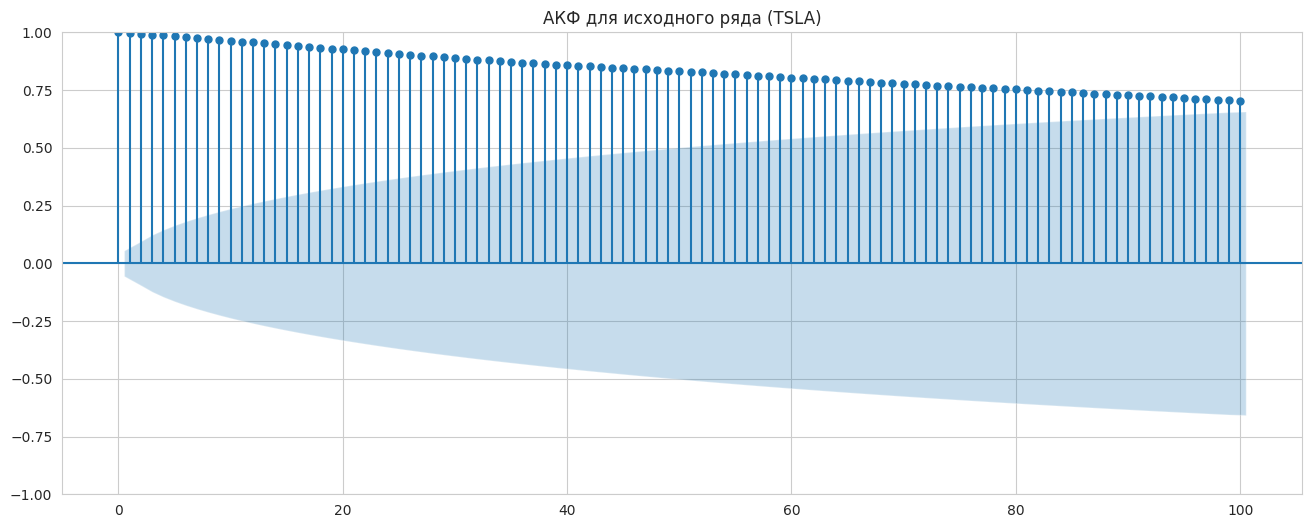

<Figure size 1600x600 with 0 Axes>

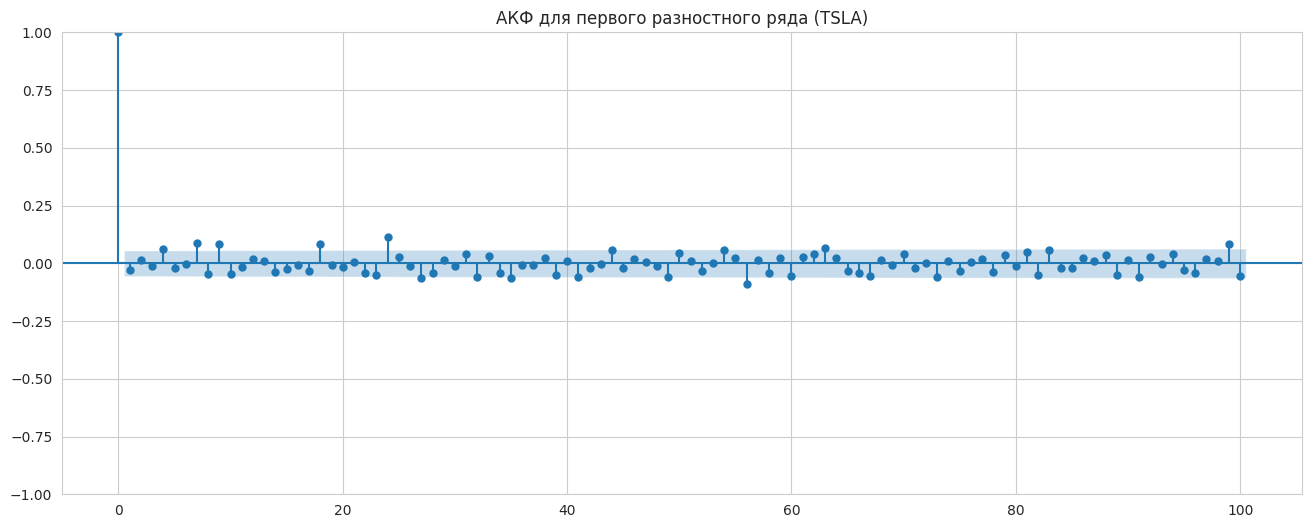

<Figure size 1600x600 with 0 Axes>

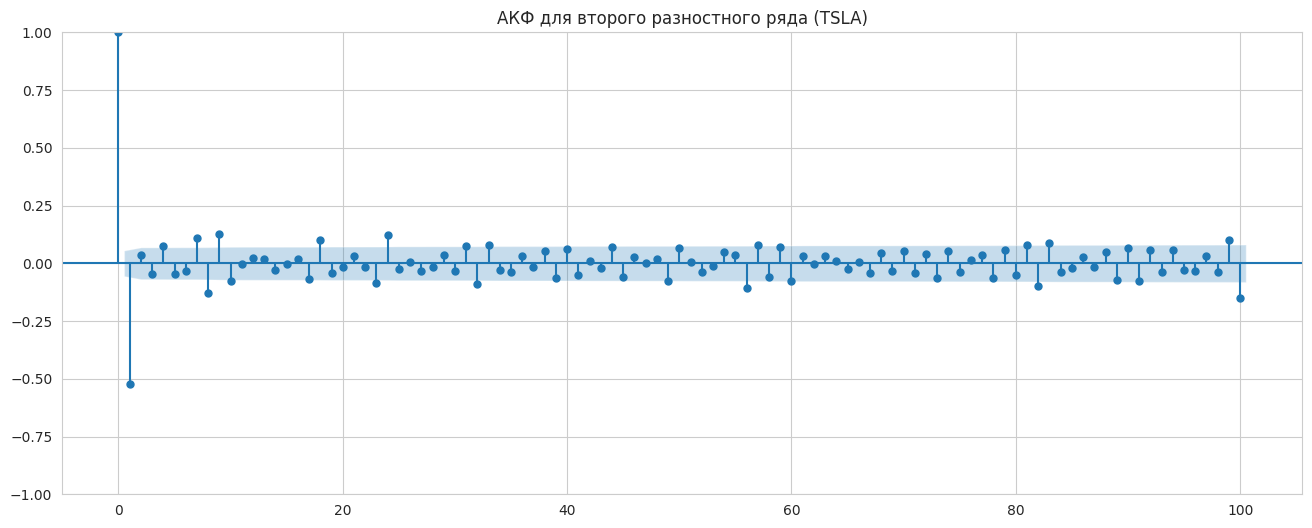

In [19]:
num_lags = 100

fig = plt.figure()
plot_acf(data_series, lags=num_lags, title=f'АКФ для исходного ряда ({ticker})')
plt.show()

fig = plt.figure()
plot_acf(diff_series_1, lags=num_lags, title=f'АКФ для первого разностного ряда ({ticker})')
plt.show()

fig = plt.figure()
plot_acf(diff_series_2, lags=num_lags, title=f'АКФ для второго разностного ряда ({ticker})')
plt.show()

#### Выводы о наличии трендов, сезонности и т.д. на основе АКФ

- **АКФ исходного ряда**:
  - Мы видим много убывающих значений вне синего доверительного интервала,оставаясь значительно выше него, что значит, что есть тренд и ряд не стационарен
  - На графике нет явных повторений значений, что значит, что нет сезонности.

- **АКФ первого разностного ряда**:
  - Значения сразу падают в синий доверительный интервал и колеблются с некоторой погрешностью в его пределах. Это значит, что ряд стационарен.
  - Тут прослеживается некоторая периодичность в значениях, что, скорее всего, свидетельствует о принципах работы рынка акций: акционеры покупают и продают акции периодично.

- **АКФ второго разностного ряда**:
  - Так как первый ряд уже стал стационарным, то последующие вычисления разностных рядов для него не имеют смысла.

### 3. Тесты стационарности

- Тест Дики-Фуллера Была использована готовая реализация расширенного теста Дики-Фуллера (ADF) из библиотеки `statsmodels.tsa.stattools` (`adfuller`).

#### Тест Дики-Фуллера для исходного ряда и для разностных рядов

Применим расширенный тест Дики-Фуллера (Augmented Dickey-Fuller, ADF) для формальной проверки стационарности.
- Нулевая гипотеза (H0): ряд нестационарен.
- Альтернативная гипотеза (H1): ряд стационарен.

Если p-value теста меньше выбранного уровня значимости (0.05), мы отвергаем H0 и считаем ряд стационарным.

In [20]:
def run_adf_test(timeseries: pd.Series, series_name: str) -> None:

    print(f'\nТест Дики-Фуллера для: {series_name}')

    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Количество лагов использовано: {result[2]}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] <= 0.05:
        print("Вывод: Ряд стационарен (отвергаем H0)")
    else:
        print("Вывод: Ряд не стационарен (не можем отвергнуть H0)")


run_adf_test(data_series, 'Исходный ряд')
run_adf_test(diff_series_1, 'Первый разностный ряд')
run_adf_test(diff_series_2, 'Второй разностный ряд')


Тест Дики-Фуллера для: Исходный ряд
ADF Statistic: -1.6910
p-value: 0.4357
Количество лагов использовано: 9
Критические значения:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Вывод: Ряд не стационарен (не можем отвергнуть H0)

Тест Дики-Фуллера для: Первый разностный ряд
ADF Statistic: -6.6934
p-value: 0.0000
Количество лагов использовано: 23
Критические значения:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Вывод: Ряд стационарен (отвергаем H0)

Тест Дики-Фуллера для: Второй разностный ряд
ADF Statistic: -12.8662
p-value: 0.0000
Количество лагов использовано: 23
Критические значения:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Вывод: Ряд стационарен (отвергаем H0)


**Выводы по тесту Дики-Фуллера:**
- **Исходный ряд**: p-value значительно больше 0.05. Это подтверждает, что исходный ряд нестационарен (не отвергаем H0).
- **Первый разностный ряд**: p-value = 0. Это позволяет отвергнуть H0 и заключить, что первый разностный ряд стационарен.
- **Второй разностный ряд**: p-value = 0, подтверждая стационарность.

### 4. Экспоненциальное сглаживание

#### Построение сглаженных рядов при различных параметрах сглаживания

Реализуем простое экспоненциальное сглаживание.

Формула: $S(t) = alpha \cdot y_t + (1 - alpha) \cdot S_{t-1}$,

где $S(t)$ — сглаженное значение в момент $t$, $y(t)$ — фактическое значение, $alpha$ — параметр сглаживания (0 < alpha < 1).
В качестве начального значения $S(0)$ возьмем $y(0)$.

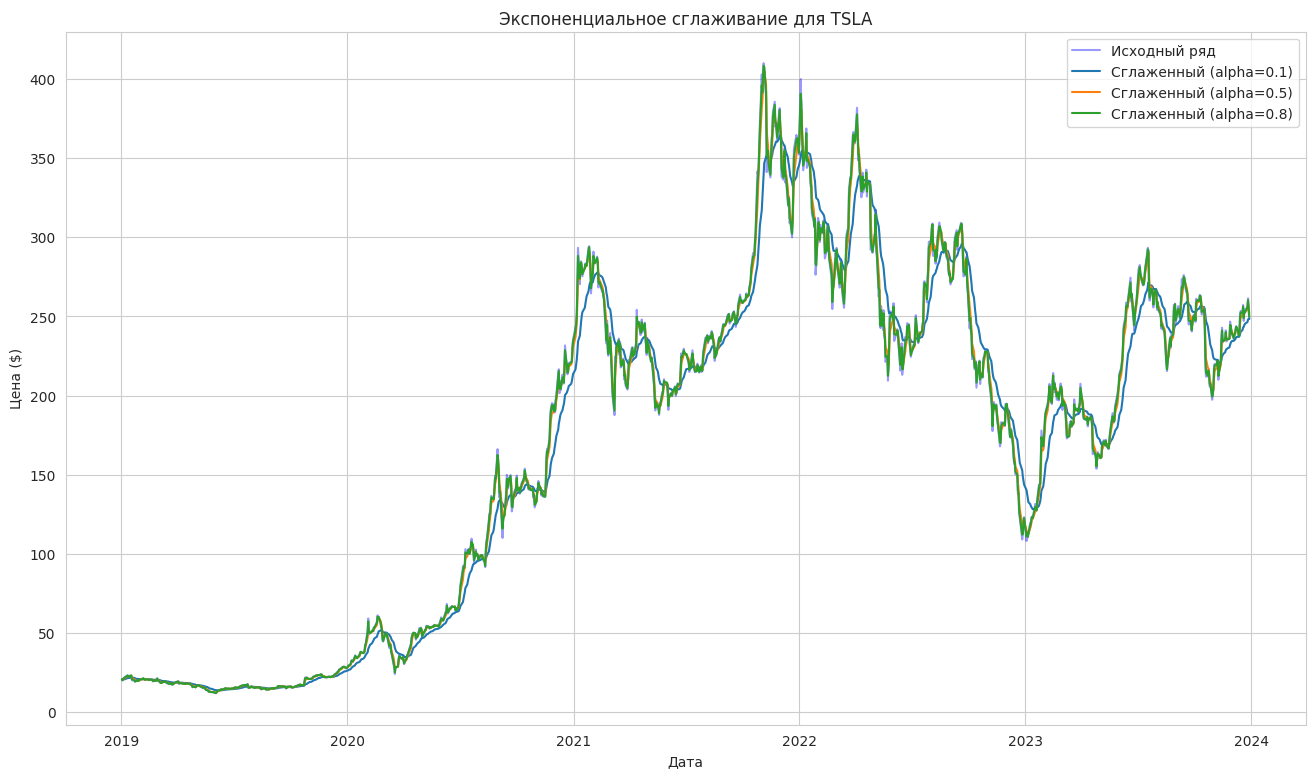

In [21]:
def simple_exponential_smoothing(data_series, alpha_val):

    result = pd.Series(index=data_series.index, dtype='float64', name=f'{data_series.name}_smoothed_alpha_{alpha_val}')

    if len(data_series) == 0:
        return result

    result.iloc[0] = data_series.iloc[0]

    for t in range(1, len(data_series)):
        result.iloc[t] = alpha_val * data_series.iloc[t] + (1 - alpha_val) * result.iloc[t-1]

    return result

alphas_to_try = [0.1, 0.5, 0.8]

fig = plt.figure(figsize=(16, 9))
plt.plot(data_series, label='Исходный ряд', color='blue', alpha=0.4)

for current_alpha in alphas_to_try:
    smoothed_series = simple_exponential_smoothing(data_series, current_alpha)
    plt.plot(smoothed_series, label=f'Сглаженный (alpha={current_alpha})')

plt.title(f'Экспоненциальное сглаживание для {ticker}')
plt.xlabel('Дата')
plt.ylabel('Цена ($)')
plt.legend()
plt.show()

#### Выводы по экспоненциальному сглаживанию.

- Малый `alpha` (0.1):
  - Придает больший вес прошлым сглаженным значениям и меньший — текущему наблюдению.
  - В результате получается очень гладкий ряд, который медленно реагирует на краткосрочные колебания и лучше отражает долгосрочную тенденцию.

- Средний `alpha` (0.5):
  - Представляет собой компромисс между гладкостью и скоростью реакции на изменения.

- Большой `alpha`(0.8):
  - Придает больший вес текущему наблюдению и меньший — прошлым сглаженным значениям.
  - Сглаженный ряд очень близко следует за исходными данными.
  - Он быстро адаптируется к новым наблюдениям, но при этом сохраняет большую часть шума и волатильности исходного ряда.

Выбор `alpha` зависит от цели анализа:
- Если цель — выявить основную долгосрочную тенденцию и максимально подавить шум, лучше использовать меньшие значения `alpha`.
- Если цель — отслеживать недавние изменения и обеспечить быструю реакцию модели на новые данные (например, в системах краткосрочного прогнозирования), предпочтительны большие значения `alpha`.

# Заключение

В ходе выполнения данной лабораторной работы был проведен комплексный анализ временного ряда цен закрытия акций (на примере TESLA, TSLA) за период с начала 2019 по конец 2023 года. Были выполнены следующие шаги и получены соответствующие выводы:

1.  **Визуализация и предварительный анализ**:
    *   Исходный ряд цен акций показал наличие выраженного восходящего тренда и изменяющейся со временем волатильности Это типично для многих финансовых активов.
    *   Построение разностных рядов (первого и второго порядка) продемонстрировало, что уже первый порядок эффективно устраняет тренд, делая среднее значение ряда близким к нулю и визуально более стационарным.

2.  **Анализ автокорреляционной функции (АКФ)**:
    *   АКФ исходного ряда характеризовалась медленным затуханием, что является классическим признаком наличия сильного тренда и, как следствие, нестационарности ряда.
    *   АКФ первого разностного ряда, напротив, быстро затухала: значимые автокорреляции наблюдались лишь на первом лаге (или отсутствовали вовсе после нулевого лага). Это указало на то, что ряд, вероятно, стал стационарным после однократного дифференцирования. Явных признаков сезонности в  данных обнаружено не было. Обнаружена некоторая периодичность в пределах недели.

3.  **Тесты стационарности (Расширенный тест Дики-Фуллера, ADF)**:
    *   Формальный тест ADF подтвердил выводы визуального и АКФ-анализа: исходный ряд нестационарный (p-value > 0.05).
    *   Для первого разностного ряда тест ADF показал стационарность (p-value < 0.05).
    *   Второй разностный ряд также оказался стационарным. Однако, учитывая стационарность уже первого разностного ряда, его использование обычно является достаточным и предпочтительным во избежание избыточного вычисления.

4.  **Экспоненциальное сглаживание**:
    *   Была успешно самостоятельно реализована функция простого экспоненциального сглаживания (SES).
    *   Применение SES с различными значениями параметра `alpha` наглядно продемонстрировало его влияние на степень сглаженности результирующего ряда:
        *   Малые `alpha` (например, 0.1) приводят к более гладкому ряду, который лучше отражает долгосрочные тенденции, но медленнее реагирует на новые данные и может запаздывать.
        *   Большие `alpha` (например, 0.8) позволяют сглаженному ряду быстрее адаптироваться к свежим данным и точнее следовать за краткосрочными изменениями, но при этом сохраняют больше исходного шума.